<a href="https://colab.research.google.com/github/pramodkoujalagi/Char-isma/blob/main/Char_isma_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# p = ['pramod', 'pratham']

In [5]:
# for w in p[:1]:
#   for ch1, ch2 in zip(w, w[1:]):
#       print(ch1, ch2)

In [6]:
# w

In [7]:
# w[1:]

In [8]:
len(words)

32033

## Building the vocabulary of characters & mappings to the integers and vice-versa

In [9]:
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [10]:
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [11]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Building the dataset

In [12]:
# Block size is nothing but the context length or the number of character I am taking to predict the next character.
block_size = 3

In [13]:
def dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      Xi = stoi[ch]
      X.append(context)
      Y.append(Xi)
      context = context[1:] + [Xi]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

In [14]:
import random
random.seed(42)
random.shuffle(words)
g1 = int(0.8*len(words))
g2 = int(0.9*len(words))

In [15]:
X_train, Y_train = dataset(words[:g1])
X_val, Y_val = dataset(words[g1:g2])
X_test, Y_test = dataset(words[g2:])

In [16]:
X_train.size()

torch.Size([182625, 3])

In [17]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Pytorch Doc: https://pytorch.org/docs/stable/generated/torch.Generator.html

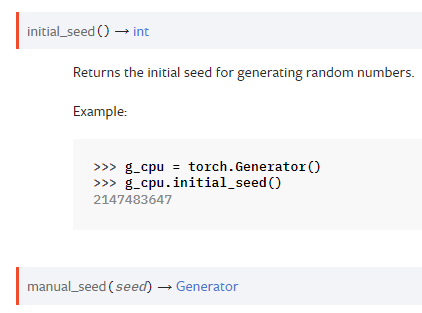

In [18]:
g_cpu = torch.Generator()
g_cpu.initial_seed()

67280421310721

In [19]:
g = torch.Generator().manual_seed(67280421310721)
C = torch.randn((27, 10), generator=g) # This is Embedding Matrix/Lookup table, similar to one present in paper
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator = g)
params = [C, W1, b1, W2, b2]

In [20]:
sum(p.nelement() for p in params)

11897

So it's a language model with 11K parameters approx. Parameters can be increased by increasing input, hidden layer neurons etc

In [21]:
for p in params:
  p.requires_grad = True # By default Pytorch assumes false for grads

In [22]:
learning_rate = torch.linspace(-3, 0, 100)
learning_rate = torch.exp(learning_rate)

In [23]:
lri = []
lossi = []
stepi = []

In [35]:
for i in range(150000):

  # small batch
  Xi = torch.randint(0, X_train.shape[0], (32,))

  # Forward pass
  embeddings = C[X_train[Xi]]
  h = torch.tanh(embeddings.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[Xi])

  # Backward pass
  for p in params:
    p.grad = None
  loss.backward()

  lr = 0.1 if i<50000 else 0.01 # Learning rate decay
  for p in params:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

In [36]:
print(loss.item())

2.0784671306610107


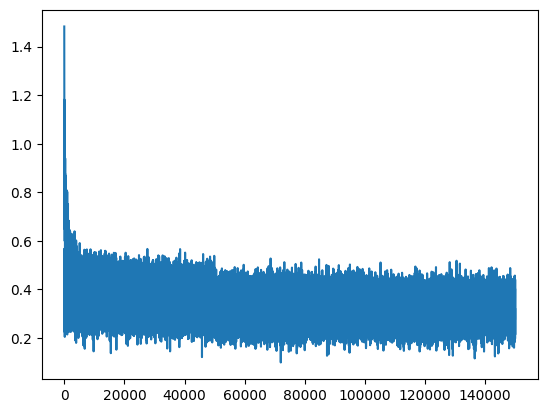

In [37]:
plt.plot(stepi, lossi)

Training loss

In [38]:
embeddings = C[X_train]
h = torch.tanh(embeddings.view(-1, 30) @W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("Training loss:", loss.item())

Training loss: 2.118220329284668


Validation loss

In [39]:
embeddings = C[X_val]
h = torch.tanh(embeddings.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print(f"Val loss:", loss.item())

Val loss: 2.1693458557128906


Test loss

In [41]:
embeddings = C[X_test]
h = torch.tanh(embeddings.view(-1, 30) @ W1+b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("Test loss:", loss.item())

Test loss: 2.166947603225708


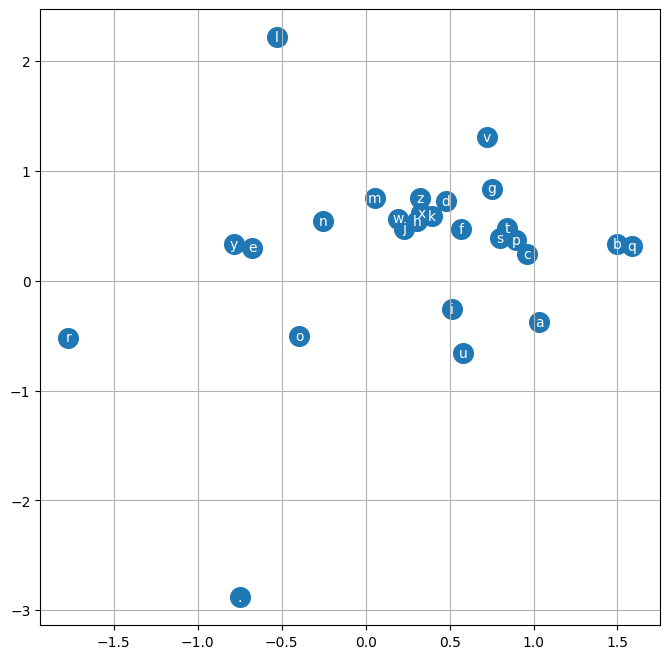

In [42]:
# visualizing dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Sample from the model

In [46]:
g = torch.Generator().manual_seed(67280421310721 + 12)

for _ in range(25):
  out = []
  context = [0] * block_size
  while True:
    embeddings = C[torch.tensor([context])]
    h = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    prob = F.softmax(logits, dim=1)
    Xi = torch.multinomial(prob, num_samples=1, generator=g).item()
    context = context[1:] + [Xi]
    out.append(Xi)
    if Xi == 0:
      break

  print(''.join(itos[i] for i in out))


buskyngelianna.
wie.
adalaya.
sia.
jazamayshboz.
tael.
muldamarickonn.
emmaryn.
brina.
layline.
kaajurgo.
azareellenn.
azaria.
bustison.
koha.
bree.
jahlir.
sha.
mhonita.
kabdrick.
addylynn.
jucelyn.
nar.
tpiah.
jozan.
